<a href="https://colab.research.google.com/github/Denev6/practice/blob/main/cnn_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchsummary

# CNN 살펴보기

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt

import warnings
from google.colab import drive

In [ ]:
drive.mount("/content/drive")
warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"

data_path = "/content/drive/MyDrive/MNIST"
learning_rate = 0.001
training_epochs = 5
batch_size = 64

Mounted at /content/drive


## Dataset

In [ ]:
mnist_train = datasets.MNIST(
    root=data_path, train=True, transform=transforms.ToTensor(), download=True
)

mnist_test = datasets.MNIST(
    root=data_path, train=False, transform=transforms.ToTensor(), download=True
)

data_loader = torch.utils.data.DataLoader(
    dataset=mnist_train, batch_size=batch_size, shuffle=True
)

In [ ]:
print("X", mnist_train.train_data.size())
print("y", mnist_train.train_labels.size())

X torch.Size([60000, 28, 28])
y torch.Size([60000])


## CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_label=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
            #       Input =  (-1,  1, 28, 28)
            # Conv + ReLU -> (-1, 16, 26, 26)
            #        Pool -> (-1, 16, 14, 14)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
            #       Input =  (-1, 16, 14, 14)
            # Conv + ReLU -> (-1, 32, 12, 12)
            #        Pool -> (-1, 32,  7,  7)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(1, -1),
            nn.Linear(7 * 7 * 32, 32),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(32, num_label)
            #          Input =  (-1, 32, 7, 7)
            #        Flatten -> (-1,     1568)
            #         Linear -> (-1,       32)
            # ReLU + Dropout -> (-1,       32)
            #         Output -> (-1,       10)
        )

    def forward(self, x, get_features=False):
        if get_features:
            # 내부 학습 과정 확인
            features = list()
            out = self.conv1(x)
            features.append(out[0])
            out = self.conv2(out)
            features.append(out[0])
            out = self.classifier(out)
            features.append(out[0])
            return features
        else:
            # 일반적인 학습 과정
            out = self.conv1(x)
            out = self.conv2(out)
            out = self.classifier(out)
            return out

In [ ]:
model = CNN()
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=32, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 12, 12]           4,640
              ReLU-5           [-1, 32, 12, 12]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
           Flatten-7                 [-1, 1568]               0
            Linear-8                   [-1, 32]          50,208
              ReLU-9                   [-1, 32]               0
          Dropout-10                   [-1, 32]               0
           Linear-11                   [-1, 10]             330
Total params: 55,338
Trainable params: 55,338
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## Train

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion.to(device)

In [ ]:
for epoch in range(1, training_epochs + 1):
    train_loss = 0
    model.train()
    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss

    train_loss /= len(data_loader)

    print(f"Epoch: {epoch}, Train Loss: {train_loss:.5f}")

Epoch: 1, Train Loss: 0.58110
Epoch: 2, Train Loss: 0.26693
Epoch: 3, Train Loss: 0.20551
Epoch: 4, Train Loss: 0.17610
Epoch: 5, Train Loss: 0.16163


## Test

In [ ]:
with torch.no_grad():
    model.eval()
    test_set = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    labels = mnist_test.test_labels.to(device)

    pred = model(test_set)
    correct = pred.argmax(-1) == labels
    accuracy = correct.float().mean()
    print(f"Accuracy: {accuracy.item():.5f}")

Accuracy: 0.97910


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/MNIST/cnn.pth")

## Features

In [ ]:
model.eval()
images, labels = next(iter(data_loader))
feat1, feat2, logits = model(images.to(device), get_features=True)

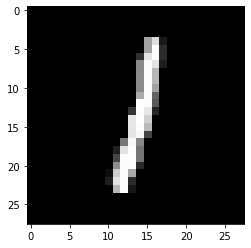

In [ ]:
plt.imshow(images[0].reshape(28, 28), cmap="gray")
plt.show()

In [ ]:
feat1.size()

torch.Size([16, 14, 14])

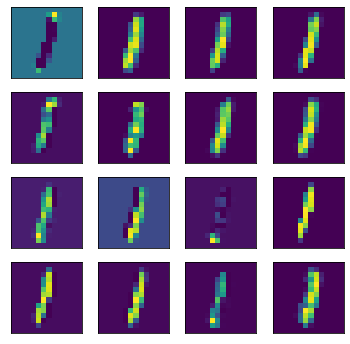

In [ ]:
feat1 = feat1.detach().cpu().numpy()

plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(feat1[i].reshape(14, 14))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
feat2.size()

torch.Size([32, 7, 7])

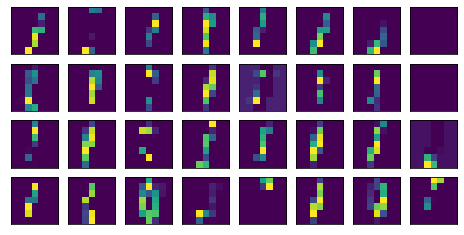

In [ ]:
feat2 = feat2.detach().cpu().numpy()

plt.figure(figsize=(8, 4))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(feat2[i].reshape(7, 7))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
logits.size()

torch.Size([10])

In [ ]:
probs = F.softmax(logits)
pred = probs.argmax(-1)

print(
    "Logits:",
    ", ".join(map(lambda x: f"{x:.3f}", logits.detach().cpu().numpy().tolist())),
)
print(
    " Probs: ",
    ", ".join(map(lambda x: f"{x:.3f}", probs.detach().cpu().numpy().tolist())),
)
print("  Pred: ", pred.detach().cpu().numpy().tolist())
print("  True: ", labels[0].numpy().tolist())

Logits: -7.427, 8.698, 0.407, -4.990, -4.264, -3.783, -4.286, -3.159, -2.024, -4.415
 Probs:  0.000, 1.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000
  Pred:  1
  True:  1


## Filters

torch.Size([16, 1, 3, 3])


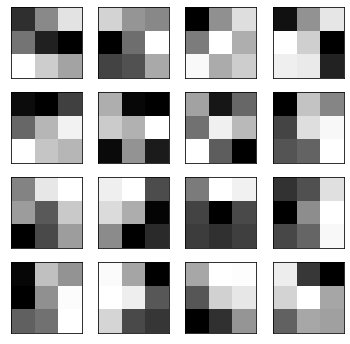

In [ ]:
filters = model.conv1[0].weight.data
print(filters.size())
filters = filters[:, 0, :, :].detach().cpu().numpy()

plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(filters[i], cmap="gray")
    plt.xticks([])
    plt.yticks([])
plt.show()

torch.Size([32, 16, 3, 3])


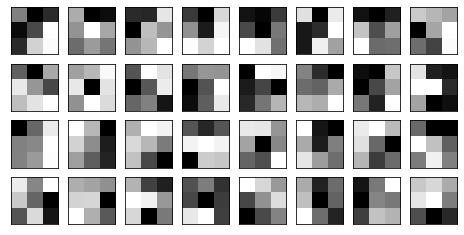

In [ ]:
filters = model.conv2[0].weight.data
print(filters.size())
filters = filters[:, 0, :, :].detach().cpu().numpy()

plt.figure(figsize=(8, 4))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(filters[i], cmap="gray")
    plt.xticks([])
    plt.yticks([])
plt.show()